In [25]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, permute_edges, block_permute, permute_matrix, triu_no_diag, to_distance_mtx, identity, power

### Preprocessing

In [2]:
chem_male = pd.read_csv('../celegans_data/male_chem_A_full_undirected.csv', header=None).values
gap_male = pd.read_csv('../celegans_data/male_gap_A_full_undirected.csv', header=None).values

In [3]:
chem_male.shape

(575, 575)

In [4]:
gap_male.shape

(585, 585)

In [5]:
chem_male, gap_male = get_multigraph_intersect_lcc([chem_male, gap_male])

chem_male = np.where(chem_male > 0, 1, 0).astype(float)
gap_male = np.where(gap_male > 0, 1, 0).astype(float)

In [6]:
chem_male.shape

(455, 455)

In [37]:
chem_cell = pd.read_csv('../celegans_data/male_chem_full_cells.csv', header=None)
gap_cell = pd.read_csv('../celegans_data/male_gap_full_cells.csv', header=None)

chem_cell = np.squeeze(chem_cell.values)
gap_cell = np.squeeze(gap_cell.values)

gap_not_chem = np.setdiff1d(gap_cell, chem_cell)
chem_not_gap = np.setdiff1d(chem_cell, gap_cell)

In [38]:
gap_not_chem.size

18

In [39]:
chem_not_gap.size

8

In [45]:
np.where(np.isin(chem_cell, chem_not_gap))

(array([ 44,  47,  48,  49, 432, 567, 572, 574]),)

In [46]:
np.where(np.isin(gap_cell, gap_not_chem))

(array([ 23,  37,  39,  40,  41,  42,  46,  47,  49,  50,  51, 438, 574,
        576, 579, 580, 582, 584]),)

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
random_state = None
num_rep = 500
rand = np.zeros(num_rep)
for i in tqdm(range(num_rep)):
    ba1 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    ba2 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    rand[i] = adjusted_rand_score(ba1, ba2)

100%|██████████| 500/500 [05:50<00:00,  1.37it/s]


Text(0, 0.5, 'Number of Occurences')

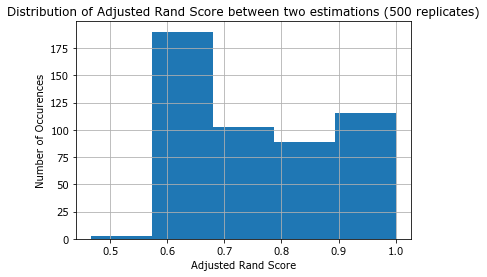

In [60]:
plt.hist(rand, bins=5)
plt.grid()
plt.title('Distribution of Adjusted Rand Score between two estimations (500 replicates)')
plt.xlabel('Adjusted Rand Score')
plt.ylabel('Number of Occurences')

In [61]:
rep = 500
num_blocks = np.zeros(rep)
for i in tqdm(range(rep)):
    block_assignment = estimate_block_assignment(chem_male, gap_male, k=10)
    num_blocks[i] = np.unique(block_assignment).size

100%|██████████| 500/500 [03:01<00:00,  2.74it/s]


In [62]:
np.arange(np.amin(num_blocks), np.amax(num_blocks)+2)

array([3., 4., 5., 6., 7., 8., 9.])

Text(0, 0.5, 'Number of Occurences')

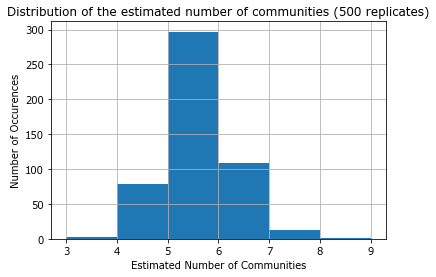

In [63]:
plt.hist(num_blocks, bins=np.arange(np.amin(num_blocks), np.amax(num_blocks)+2))
plt.grid()
plt.title('Distribution of the estimated number of communities (500 replicates)')
plt.xlabel('Estimated Number of Communities')
plt.ylabel('Number of Occurences')

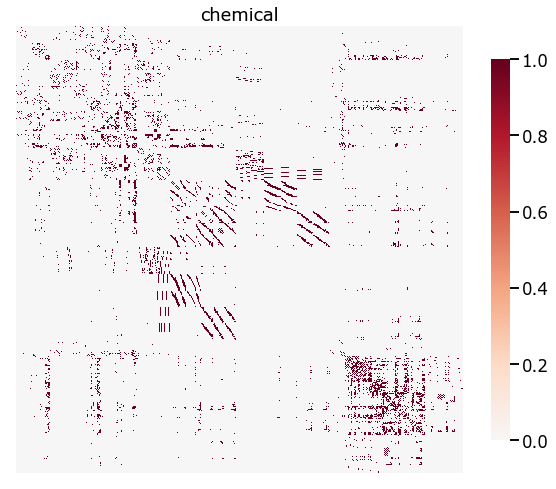

In [30]:
heatmap(chem_male, title='chemical')

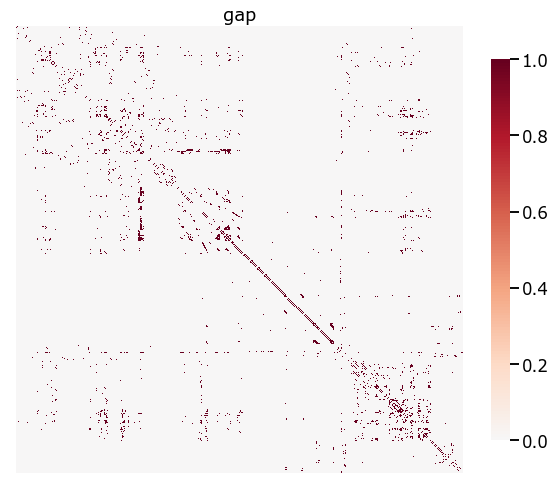

In [31]:
heatmap(gap_male, title='gap')

In [68]:
block_assignment = estimate_block_assignment(chem_male, gap_male, k=10)

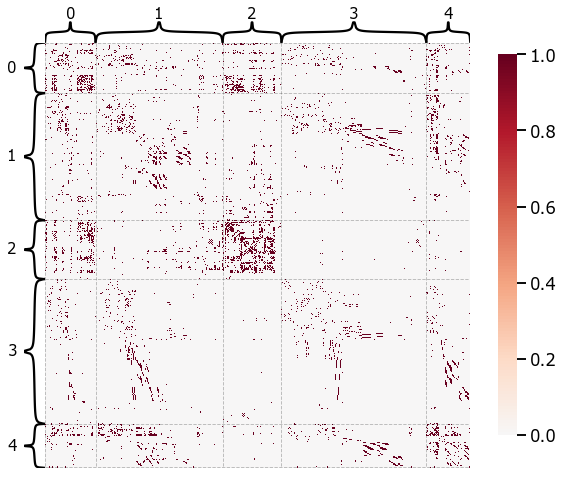

In [69]:
heatmap(chem_male, title='chemical', inner_hier_labels=block_assignment)

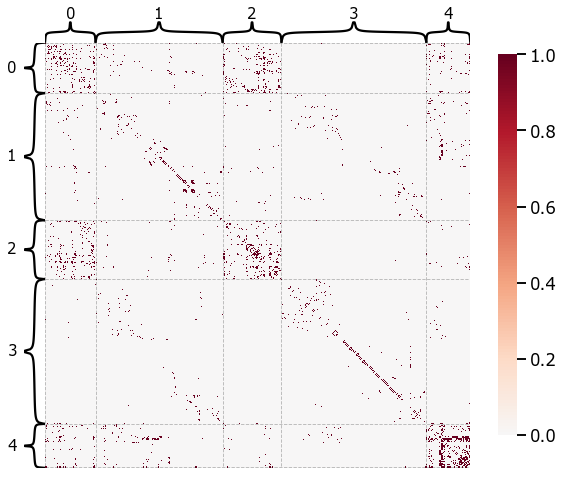

In [70]:
heatmap(gap_male, inner_hier_labels=block_assignment, title='gap')

In [14]:
def block_permute_old(A, block_assignment):
    permuted_A = np.zeros_like(A)
    unique_blocks = np.unique(block_assignment)
    for i in unique_blocks:
        block_i_idx = np.where(block_assignment == i)[0]
        for j in unique_blocks:
            block_j_idx = np.where(block_assignment == j)[0]
            block = A[np.ix_(block_i_idx, block_j_idx)]
            if i == j:
                permuted_block = permute_matrix(block)
            else:
                permuted_block = np.random.permutation(block)
            permuted_A[np.ix_(block_i_idx, block_j_idx)] = permuted_block
    permuted_A = symmetrize(permuted_A)
    return permuted_A

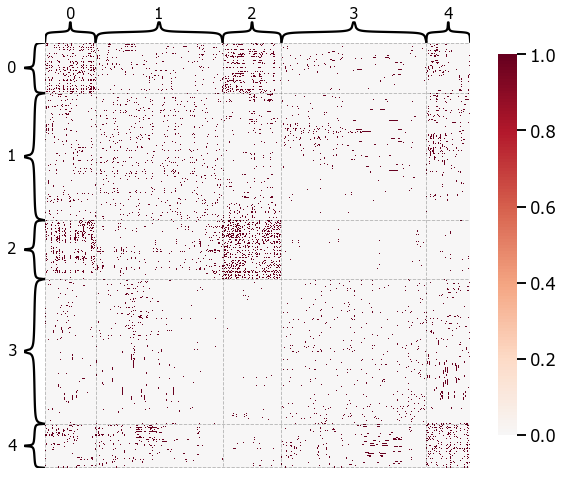

In [71]:
heatmap(block_permute_old(chem_male, block_assignment), inner_hier_labels=block_assignment)

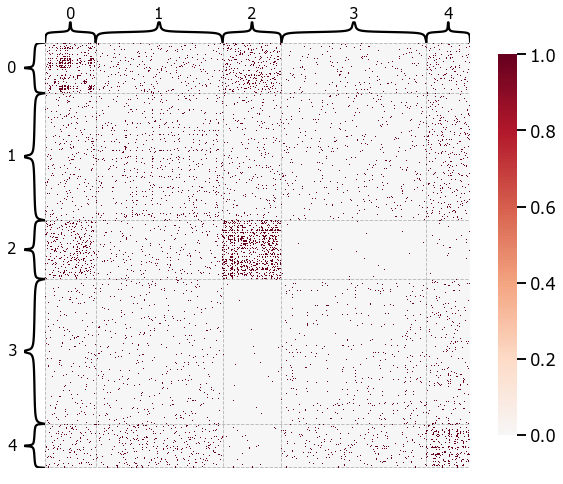

In [72]:
heatmap(block_permute(chem_male, block_assignment), inner_hier_labels=block_assignment)

### Fit model

In [19]:
mgc = MGC(compute_distance_matrix=identity)

In [20]:
def pvalue(A, B, indept_test, transform_func, k=10, null_mc=500):
    test_stat_alternative, _ = indept_test.test_statistic(
        matrix_X=transform_func(A), matrix_Y=transform_func(B))

    block_assignment = estimate_block_assignment(A, B, k=k)
    
    test_stat_null_array = np.zeros(null_mc)
    for j in tqdm(range(null_mc)):
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[j] = test_stat_null

    p_value = np.where(test_stat_null_array > test_stat_alternative)[
        0].shape[0] / test_stat_null_array.shape[0]
    return p_value

In [21]:
pval = pvalue(A=chem_male, B=gap_male, indept_test=mgc, transform_func=to_distance_mtx)

100%|██████████| 500/500 [04:37<00:00,  1.87it/s]


In [22]:
pval

0.356

In [18]:
num_block

5

In [84]:
mgc.test_statistic(to_distance_mtx(chem_male), to_distance_mtx(gap_male))

(0.03714785081262196,
 {'local_correlation_matrix': array([[0.03714785, 0.03484336],
         [0.03534879, 0.03293405]]), 'optimal_scale': [1, 1]})

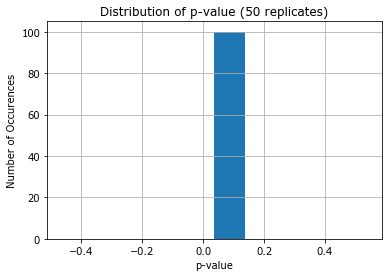

In [82]:
plt.hist(test_stats)
plt.title('Distribution of p-value (50 replicates)')
plt.xlabel('p-value')
plt.ylabel('Number of Occurences')
plt.grid()

In [73]:
with open('../celegans_data/pvalue.pkl', 'rb') as f:
    pval = pickle.load(f)

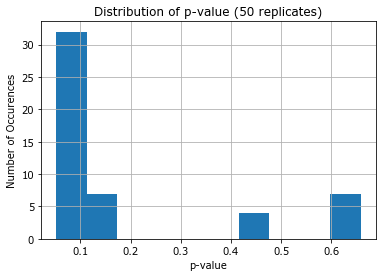

In [76]:
plt.hist(pval)
plt.title('Distribution of p-value (50 replicates)')
plt.xlabel('p-value')
plt.ylabel('Number of Occurences')
plt.grid()

In [79]:
min(pval)

0.052